In [ ]:
!ls

In [ ]:
import pandas as pd 
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt 
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,7)

import catboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
from sklearn.metrics import make_scorer 
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor


In [ ]:
train_df = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test_df = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full_df = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [ ]:
dfs = [train_df, test_df, full_df]

In [ ]:
train_df['rougher.output.recovery'] #то что перепроверям 

In [ ]:
train_df.info()

In [ ]:
#display(train_df.iloc[:, 30:65].head())
display(train_df.iloc[:, 30:65].columns)

сначала нужно посчитть это: 

- C — доля золота в концентрате после флотации/очистки; (+) (rougher.output.feed_au_share)
- F — доля золота в сырье/концентрате до флотации/очистки; (+) (rougher.input.feed_au_share)
- T — доля золота в отвальных хвостах после флотации/очистки.

In [ ]:
 #rougher.output.concentrate_au - rougher.input.feed_au - rougher.output.tail_au
train_df[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']]

C = train_df['rougher.output.concentrate_au']
F = train_df['rougher.input.feed_au']
T = train_df['rougher.output.tail_au']

train_df['recovery_test'] = (C*(F-T))/(F*(C-T))*100


In [ ]:
#посмотрим что без нанов 
print(mean_absolute_error(train_df.dropna(subset=['recovery_test'])['rougher.output.recovery'], 
                            train_df.dropna(subset=['recovery_test'])['recovery_test']))

In [ ]:
test_df.isnull().sum().sort_values(ascending=False)

In [ ]:
print('columns in train', len(train_df.columns))
print('columns in test', len(test_df.columns))

print(len(set(train_df.columns).difference(set(test_df.columns))))
train_test_dif_cols = set(train_df.columns).difference(set(test_df.columns))

In [ ]:
from pprint import pprint 
pprint(train_test_dif_cols)

In [ ]:
train_df[list(train_test_dif_cols)].info()

Что можно сделать в предобработке: 

1. удалить из train колонки, которые недоступны в test (позже)
2. Удалить пропуски, если их немного 
3. сбросить дубликаты 

In [ ]:
cols = test_df.columns

for df in dfs: 
    #проверка на дубликаты 
    print(len(df.columns))
    #тут пока непонятно, стоит ли до EDA удалять колонки 
    #df = df[cols]
    print(len(df.columns))
    print(df.shape)
    print(df.duplicated().sum())
    print(df.isnull().sum().sort_values(ascending=False))
    

In [ ]:
#словарь столбцов с инпутом и аутпутом в этапах, чтобы проще было ковыряться в этом безобразии
l_cols = {}

for l in ['rougher', 'primary_cleaner',
           'secondary_cleaner', 'final']:
    
    l_cols[l] = {}
    l_cols[l]['input'] = []
    l_cols[l]['output'] = []

    print(l)
    
    for col in full_df.columns:

        if l == col.split('.')[0] and col.split('.')[1] == 'input':
            l_cols[l]['input'].append(col)
        elif l == col.split('.')[0] and col.split('.')[1] == 'output':
            l_cols[l]['output'].append(col)
        else:
            continue

### rougher

In [ ]:
l_cols['rougher']['output']

In [ ]:
train_df['rougher.input.feed_au'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.concentrate_au'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.tail_au'].hist(alpha = 0.5, bins =30)
plt.title('Au distribution in rougher')
plt.legend(['input.feed_au', 'output.concentrate_au', 'output.tail_au'])
plt.show()

In [ ]:
train_df['rougher.input.feed_ag'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.concentrate_ag'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.tail_ag'].hist(alpha = 0.5, bins =30)
plt.title('Ag distribution in rougher')
plt.legend(['input.feed_ag', 'output.concentrate_ag', 'output.tail_ag'])
plt.show()

In [ ]:
train_df['rougher.input.feed_pb'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.concentrate_pb'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.tail_pb'].hist(alpha = 0.5, bins =30)
plt.title('Pb distribution in rougher')
plt.legend(['input.feed_pb', 'output.concentrate_pb', 'output.tail_pb'])
plt.show()

Получается, что даже первый этап грубой очистки уже справляется со своей работой. 

Особенно хорошо он справляется с золотом и свинцом, хуже справляется с серебром при этом. 

### primary_cleaner

In [ ]:
l_cols['primary_cleaner']

In [ ]:
#сравним что получилось после первого этапа чистки по металлам 
train_df['primary_cleaner.output.concentrate_ag'].hist(alpha = 0.5, bins = 30)
train_df['primary_cleaner.output.concentrate_pb'].hist(alpha = 0.5, bins = 30)
train_df['primary_cleaner.output.concentrate_au'].hist(alpha = 0.5, bins =30)
plt.title('Feed distribution in the first cleaner')
plt.legend(['Ag', 'Pb', 'Au'])
plt.show()

Видно, что на этом этапе очень сильно удается выделить из входящей массы серебро

### secondary cleaner

In [ ]:
l_cols['secondary_cleaner']

In [ ]:
#сравним что получилось после второго этапа чистки по металлам 
train_df['secondary_cleaner.output.tail_ag'].hist(alpha = 0.5, bins = 30)
train_df['secondary_cleaner.output.tail_pb'].hist(alpha = 0.5, bins = 30)
train_df['secondary_cleaner.output.tail_au'].hist(alpha = 0.5, bins =30)
plt.title('Feed distribution in the second cleaner')
plt.legend(['Ag', 'Pb', 'Au'])
plt.show()

на вторичном этапе очистки довольно большой % серебра уходит в остатки, меньше всего в остатки уходит золото

### final

In [ ]:
l_cols['final']

In [ ]:
#сравним что получилось после второго этапа чистки по металлам 
train_df['final.output.concentrate_ag'].hist(alpha = 0.5, bins = 30)
train_df['final.output.concentrate_pb'].hist(alpha = 0.5, bins = 30)
train_df['final.output.concentrate_au'].hist(alpha = 0.5, bins =30)
plt.title('Feed distribution on final stage')
plt.legend(['Ag', 'Pb', 'Au'])
plt.show()

на финальном этапе вообще красота, % золота очень сильно подросла и колеблется в основном от 40% до 50%. 

будем считать, что система очистки справляется со своей работой 

In [ ]:
#посмотрим какие колонки у нас есть в тестовой 
[col for col in test_df.columns if col.split('.')[-1]=='feed_size']

In [ ]:
#а какие в обучающей 
[col for col in train_df.columns if col.split('.')[-1]=='feed_size']

сравнить мы можем две одинаковые стадии между собой: отдельно rougher и первичный клинер

In [ ]:
#сравним что получилось после второго этапа чистки по металлам 

print(train_df['rougher.input.feed_size'].mean(), '-- средний размер гранул в трейн выборке')
print(test_df['rougher.input.feed_size'].mean(), '-- средний размер гранул в тест выборке')

print(train_df['rougher.input.feed_size'].median(), '-- медиана гранул в трейн выборке')
print(test_df['rougher.input.feed_size'].median(), '-- медиана размер гранул в тест выборке')

train_df['rougher.input.feed_size'].hist(alpha = 0.5, bins = 30)
test_df['rougher.input.feed_size'].hist(alpha = 0.5, bins = 30)
plt.title('Feed size distribution in rougher')
plt.legend(['train', 'test'])
plt.show()

sns.kdeplot(train_df['rougher.input.feed_size'])
sns.kdeplot(test_df['rougher.input.feed_size'])
plt.title('Feed size distribution in rougher | KDE')
plt.legend(['train', 'test'])
plt.show()

из-за выбросов в feed_size в трейн выборке не очень приятно сравнивать распределения, посмотрим без них

In [ ]:
#сравним что получилось после второго этапа чистки по металлам, немного призумимся
print(train_df[train_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].mean(), '-- средний размер гранул в трейн выборке')
print(test_df[test_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].mean(), '-- средний размер гранул в тест выборке')

print(train_df[train_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].median(), '-- медиана гранул в трейн выборке')
print(test_df[test_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].median(), '-- медиана размер гранул в тест выборке')


train_df[train_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].hist(alpha = 0.5, bins = 50)
test_df[test_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].hist(alpha = 0.5, bins = 50)
plt.title('Feed size distribution in rougher')
plt.legend(['train', 'test'])
plt.show()

sns.kdeplot(train_df[train_df['rougher.input.feed_size']<150]['rougher.input.feed_size'])
sns.kdeplot(test_df[test_df['rougher.input.feed_size']<150]['rougher.input.feed_size'])
plt.title('Feed size distribution in rougher | KDE')
plt.legend(['train', 'test'])
plt.show()


Распределение отличаюются, но все же скорее похожи друг на друга (оба смещены скорее влево). При этом надо отметить, что периодически залетают булыжники в массу сырья

In [ ]:
#а какие в обучающей 
[col for col in train_df.columns if col.split('.')[-1].split('_')[0]=='concentrate']

### rougher

In [ ]:
rougher_conc_df = train_df[['rougher.output.concentrate_ag',
                            'rougher.output.concentrate_pb',
                            'rougher.output.concentrate_sol',
                            'rougher.output.concentrate_au']].copy()

rougher_conc_df['total_conc'] = rougher_conc_df.sum(axis=1)
display(rougher_conc_df.head())

rougher_conc_df['total_conc'].hist(bins = 30)
plt.title('распредение всех полезных металлов на этапе rougher')
plt.show()

### primary_cleaner

In [ ]:
primary_cleaner_conc_df = train_df[['primary_cleaner.output.concentrate_ag',
                            'primary_cleaner.output.concentrate_pb',
                            'primary_cleaner.output.concentrate_sol',
                            'primary_cleaner.output.concentrate_au']].copy()

primary_cleaner_conc_df['total_conc'] = primary_cleaner_conc_df.sum(axis=1)
display(primary_cleaner_conc_df.head())

primary_cleaner_conc_df['total_conc'].hist(bins = 30)
plt.title('распредение всех полезных металлов на этапе primary_cleaner')
plt.show()

### secondary cleaner

In [ ]:
final_conc_df = train_df[['final.output.concentrate_ag',
                            'final.output.concentrate_pb',
                            'final.output.concentrate_sol',
                            'final.output.concentrate_au']].copy()

final_conc_df['total_conc'] = final_conc_df.sum(axis=1)
display(final_conc_df.head())

final_conc_df['total_conc'].hist(bins = 30)
plt.title('распредение всех полезных металлов на этапе final')
plt.show()

### total

In [ ]:
rougher_conc_df['total_conc'].hist(bins = 30, alpha = 0.5)
primary_cleaner_conc_df['total_conc'].hist(bins = 30, alpha = 0.5)
final_conc_df['total_conc'].hist(bins = 30, alpha = 0.5)

plt.legend(['rougher', 'primary_cleaner', 'final'])
plt.title('распредение всех полезных металлов')
plt.show()

### почистим аномалии

In [ ]:
train_df['total_conc_rougher'] = train_df[['rougher.output.concentrate_ag',
                            'rougher.output.concentrate_pb',
                            'rougher.output.concentrate_sol',
                            'rougher.output.concentrate_au']].sum(axis=1)

train_df['total_conc_pc'] = train_df[['primary_cleaner.output.concentrate_ag',
                            'primary_cleaner.output.concentrate_pb',
                            'primary_cleaner.output.concentrate_sol',
                            'primary_cleaner.output.concentrate_au']].sum(axis=1)

train_df['total_conc_sc'] = train_df[['final.output.concentrate_ag',
                            'final.output.concentrate_pb',
                            'final.output.concentrate_sol',
                            'final.output.concentrate_au']].sum(axis=1)

In [ ]:
# заданим трешхолд после которого хотим данные отсечь 
train_df[train_df['total_conc_rougher']> 20]['total_conc_rougher'].hist(bins = 30, alpha = 0.5)
train_df[train_df['total_conc_pc']> 20]['total_conc_pc'].hist(bins = 30, alpha = 0.5)
train_df[train_df['total_conc_sc']> 20]['total_conc_sc'].hist(bins = 30, alpha = 0.5)

plt.legend(['rougher', 'primary_cleaner', 'final'])
plt.title('распредение всех полезных металлов')
plt.show()

In [ ]:
train_df = train_df.query('total_conc_rougher > 20')\
                    .query('total_conc_pc > 20')\
                    .query('total_conc_sc > 20')

In [ ]:
# заданим трешхолд после которого хотим данные отсечь 
train_df['total_conc_rougher'].hist(bins = 30, alpha = 0.5)
train_df['total_conc_pc'].hist(bins = 30, alpha = 0.5)
train_df['total_conc_sc'].hist(bins = 30, alpha = 0.5)

plt.legend(['rougher', 'primary_cleaner', 'final'])
plt.title('распредение всех полезных металлов')
plt.show()

вот теперь распредления смещенные, но теперь без аномалий 

In [ ]:
train_df.columns

In [ ]:
cols = ['rougher.input.feed_ag',
         'rougher.input.feed_pb',
         'rougher.input.feed_rate',
         'rougher.input.feed_size',
         'rougher.input.feed_sol',
         'rougher.input.feed_au']

In [ ]:
for col in cols: 
    print(col)
    train_df[col].hist(bins = 100)
    plt.show()

наиболее заметные аномалии в колонке feed_size, видимо ты хотел, чтобы именно эту колонку я почистил? 

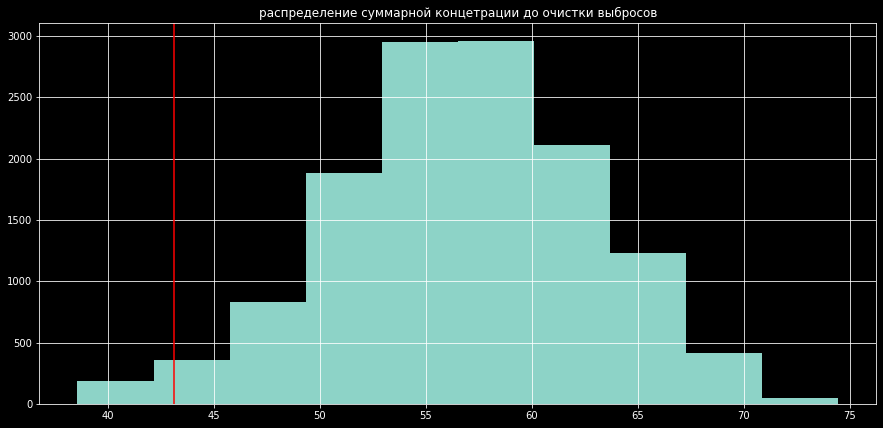

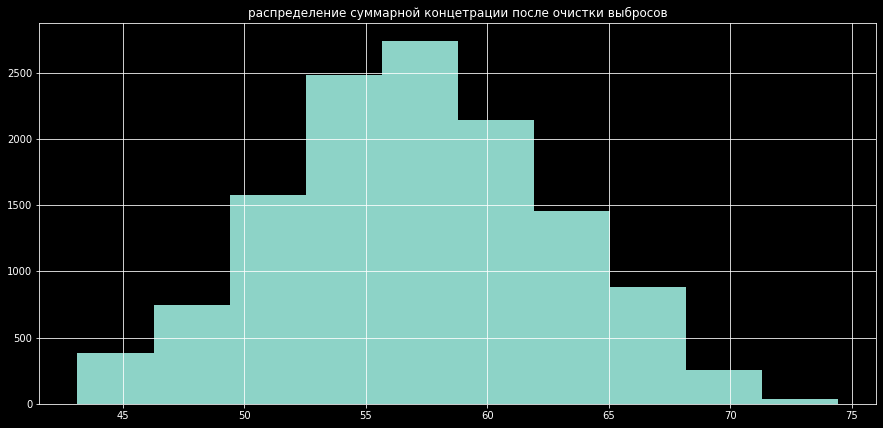

In [61]:
cols = ['rougher.input.feed_ag',
         'rougher.input.feed_pb',
         'rougher.input.feed_sol',
         'rougher.input.feed_au']
train_df['total_input_conc'] = train_df[cols].sum(axis=1)

train_df['total_input_conc'].hist()
plt.axvline(np.percentile(train_df['total_input_conc'], 2) , color= 'r')
plt.title('распределение суммарной концетрации до очистки выбросов')
plt.show()

train_df = train_df[train_df['total_input_conc'] > np.percentile(train_df['total_input_conc'], 2)]

train_df['total_input_conc'].hist()
plt.title('распределение суммарной концетрации после очистки выбросов')
plt.show()

In [62]:
display(train_df['rougher.input.feed_size'].describe(percentiles = [0, 0.5, 0.9, 0.95, 0.99]))
train_df = train_df[train_df['rougher.input.feed_size']<120]

count    12711.000000
mean        58.645258
std         13.229754
min          9.659576
0%           9.659576
50%         55.392467
90%         77.985737
95%         83.726021
99%         99.940138
max        119.664018
Name: rougher.input.feed_size, dtype: float64

<AxesSubplot:>

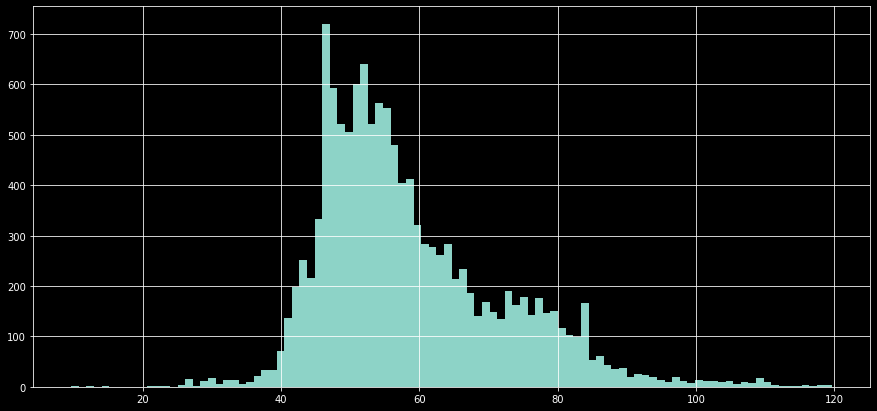

In [63]:
train_df['rougher.input.feed_size'].hist(bins = 100)

In [ ]:

rougher_conc_df[rougher_conc_df['total_conc']>np.percentile(rougher_conc_df['total_conc'], 2)]\
    ['total_conc'].hist(bins = 30, alpha = 0.5)
primary_cleaner_conc_df[primary_cleaner_conc_df['total_conc']>np.percentile(primary_cleaner_conc_df['total_conc'], 2)]\
    ['total_conc'].hist(bins = 30, alpha = 0.5)
final_conc_df[final_conc_df['total_conc']>np.percentile(final_conc_df['total_conc'], 2)]\
    ['total_conc'].hist(bins = 30, alpha = 0.5)

plt.legend(['rougher', 'primary_cleaner', 'final'])
plt.title('распредение всех полезных металлов')
plt.show()

# Modeling 

In [ ]:
def smape(target, pred): 
    smape = np.mean(abs(target-pred)/((abs(target)+abs(pred))/2)*100)
    return smape
      
scorer = make_scorer(smape, greater_is_better=False)

#почистим выбросы 
def df_clean(df_reg, features, target):
    for col in df_reg[features].columns:
        lower = np.percentile(df_reg[col], 2)
        upper = np.percentile(df_reg[col], 98)        
        df_reg = df_reg[(df_reg[col]> lower) & (df_reg[col]<upper)]
        return df_reg[features], df_reg[target]
    
def omagad_really_smape(smape_rougher, smape_final):
    return 0.25*smape_rougher+ 0.75*smape_final

### rougher 

#### df prep

In [ ]:
rougher_cols = l_cols['rougher']['input']
rougher_cols

тк модель должна давать прогноз сразу после стадии грубой очистки, логично предположить, что данные будут известны только по инпуту этого этапа

In [ ]:
target_rougher = ['rougher.output.recovery']

In [ ]:
rougher_cols = rougher_cols + target_rougher

In [ ]:
rougher_train_df = train_df[rougher_cols]

In [ ]:
display(rougher_train_df.isnull().sum().sort_values(ascending=False))

не так уж много пропусков, проще их будет удалить 

In [ ]:
print(rougher_train_df.shape)
print(rougher_train_df.dropna().shape)
rougher_train_df.dropna(inplace=True)

In [ ]:
rougher_train_df

In [ ]:
for col in rougher_train_df.columns:
    sns.boxplot(rougher_train_df[col])
    plt.title('boxplot for '+col)
    plt.show()

выбросов получается довольно много, чтобы назвать их аномалией, поэтому лучше убрать совсем по чуть-чуть с краев, чтоб захватить совсем уж странные объекты. остальное оставить. 

In [ ]:
rougher_train_df.columns[:-1]

In [ ]:
#
x, y = df_clean(rougher_train_df, rougher_train_df.columns[:-1], 'rougher.output.recovery')

#### LR

In [ ]:
#обычная линейная модель 
lr = LinearRegression()
scores = cross_val_score(lr, x, y, scoring=scorer, cv=5)
print(np.mean(scores), 'средний скор на кросс валидации для линейной модели для первого таргета') 
print(scores)
lr.fit(x,y)

#### rfr

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [x for x in range(3,15,3)],
    'n_estimators': [x for x in range(10,90,20)]
}


In [ ]:
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 10, scoring=scorer)
grid_search.fit(x, y)
print(grid_search.best_params_)
best_model_rf_rougher = grid_search.best_estimator_
best_model_rf_rougher.fit(x,y)

In [ ]:
print(grid_search.best_score_)


#### catboost

In [ ]:
ctb_rougher = catboost.CatBoostRegressor(verbose=100)

scores = cross_val_score(ctb_rougher, x, y, scoring=scorer, cv=5)

print(np.mean(scores), 'средний скор на кросс валидации для катбуста для первого таргета') 
print(scores)
ctb_rougher.fit(x,y)

##### лучшая модель rougher

лучше всего себя показала линейная регрессия на этом этапе со средним показателем скора 5.9

### final

In [ ]:
#избавимся от ненужных колонок 
target = train_df['final.output.recovery']
train_df = train_df.drop(l_cols['final']['output'] + ['date', 'recovery_test'], axis = 1)

In [ ]:
train_df = train_df[test_df.drop(['date'], axis = 1).columns].join(target)

In [ ]:
train_df

In [ ]:
train_df = train_df.dropna()
x, y = df_clean(train_df, train_df.drop(['final.output.recovery'], axis=1).columns, 
                                         'final.output.recovery')

#### lr2

In [ ]:
lr_2 = LinearRegression()
scores = cross_val_score(lr_2, x,y, scoring=scorer)
print(scores.mean())
lr_2.fit(x,y)

#### rfr2

In [ ]:
rfr2 = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rfr2, param_grid = param_grid,  
                          cv = 5, n_jobs = -1, verbose = 50, scoring=scorer)

grid_search.fit(x, y)
print(grid_search.best_params_)
print(grid_search.best_score_)
best_model_rfr2 = grid_search.best_estimator_
best_model_rfr2.fit(x,y)

In [ ]:
print(grid_search.best_score_)

#### ctb_2

In [ ]:
ctb_2 = catboost.CatBoostRegressor(verbose=100)

scores = cross_val_score(ctb_2, x, y, scoring=scorer, cv=5)

print(np.mean(scores), 'средний скор на кросс валидации для катбуста для первого таргета') 
print(scores)
ctb_2.fit(x,y)


##### выводы по моделям final 

здесь примерно похожие результаты, кэтбуст и случайный лес показали примерно одинаковые результаты, но случайный лес все же немного лучше, возьмем его 

### test

In [ ]:
test_df = test_df.merge(full_df[['date', 'rougher.output.recovery', 'final.output.recovery']],
                        how='left', on = 'date').drop(['date'], axis = 1).dropna()
target_rougher_test = test_df['rougher.output.recovery']
target_final_test = test_df['final.output.recovery']


In [ ]:
x_final = test_df.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
x_rougher = test_df[rougher_cols].drop(['rougher.output.recovery'], axis = 1)

In [ ]:
test_df

In [ ]:
pred = lr.predict(x_rougher)

smape_rougher = smape(target_rougher_test, pred)

In [ ]:
#сравним по качеству с дамми регресором 

dummy_pred = np.array([target_rougher_test.mean()] * len(pred))

smape_rougher_dummy = smape(target_rougher_test, dummy_pred)
print(smape_rougher_dummy)

In [ ]:
pred = best_model_rfr2.predict(x_final)

smape_final = smape(target_final_test, pred)
print(smape_final)

In [ ]:
#сравним по качеству с дамми регресором 

dummy_pred_final = np.array([target_final_test.mean()] * len(pred))

smape_rougher_dummy_final = smape(target_final_test, dummy_pred_final)
print(smape_rougher_dummy_final)

In [ ]:
pred = ctb_2.predict(x_final)

smape_final = smape(target_final_test, pred)
print(smape_final)

и все же кэтбуст на тестовых получше себя показывает, поэтому в итоговых расчетах будем использовать именно его 

In [ ]:
print('rougher model score on test sample', smape_rougher)
print('final smape on test sample', smape_final)

In [ ]:
smape_total = omagad_really_smape(smape_rougher, smape_final) 
print('итоговая метрика', smape_total)

In [ ]:
smape_total_dummy = omagad_really_smape(smape_rougher_dummy, smape_rougher_dummy_final) 
print('итоговая метрика', smape_total_dummy)